
# EDA and Data Cleaning

===================================

## Data Limitations

<ul>
    <li>Data was gathered from only <a href="https://www.kayak.com">Kayak</a></li>
    <li>Data collection was done from 2022-Apr-3 to 2022-Apr-10</li>
    <li>Plane Tickets were restricted to round trip tickets only</li>
    <li>All departure and return times were set to 1 week</li>
    <li>Flights were gathered for a 4 months period from 2022-Apr to 2022-Sep</li>
<ul><br>
Specifically targeted flights to three countries:
<ol>
    <li>Singapore</li>
    <li>South Korea</li>
    <li>Phuket, Thailand</li>
</ol><br>
From the following locations in the United States:
<ol>
    <li>New Jersey</li>
    <li>New York</li>
    <li>California</li>
</ol><br>
    
This was done to reduce complexity and size of the data needed for this project

---

In [1]:
# Import required packages
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import calendar

from py_files.cleaner import df_compiler # Importing compiler from pyfile

In [2]:
# Choose the zip files to merge into master dataframe
zip_path_list = ['data/EWR_to_SIN.zip', 'data/NYC_to_SIN.zip', 'data/SAN_to_SIN.zip',
                 'data/EWR_to_ICN.zip', 'data/NYC_to_ICN.zip', 'data/SAN_to_ICN.zip',
                'data/EWR_to_HKT.zip', 'data/SAN_to_HKT.zip', 'data/NYC_to_HKT.zip']
df = df_compiler(zip_path_list) # Call on df_compiler function
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58713 entries, 0 to 46
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Out Time            58713 non-null  object
 1   Out Airline         58713 non-null  object
 2   Out Cities          58713 non-null  object
 3   Out Duration        58713 non-null  object
 4   Out Stops           58713 non-null  int32 
 5   Out Stop Cities     53161 non-null  object
 6   Return Time         58713 non-null  object
 7   Return Airline      58713 non-null  object
 8   Return Cities       58713 non-null  object
 9   Return Duration     58713 non-null  object
 10  Return Stops        58713 non-null  int32 
 11  Return Stop Cities  53358 non-null  object
 12  Price               58713 non-null  int32 
 13  timestamp           58713 non-null  object
 14  sort                58713 non-null  object
 15  departure_date      58713 non-null  object
 16  total_duration      58713

We can see that there are some null values present in <code>'Out Stop Cities'</code> and <code>'Return Stop Cities'</code><br>
This is because there are one way flights included in the dataset which caused NaN values to populate as they did not have cities in those fields.

## This block of code needs to be run AFTER the whole notebook has run once

---

There is a strange bug that prevents the split function from recognizing the each individual variable as a string and instead registers is as a Series object.<br>

In [3]:
# For some reason running this code inside of my df_cleaner would return a split error
# Had to run code outside to solve this
# In addition for some reason this MUST be run after everything else has already run? Not sure why
# time_diff_list = []

# for i in range(0, len(df)):
#     dep_date_test = pd.to_datetime(df['departure_date'][i])
#     time_stamp = pd.to_datetime(df['timestamp'][i].split('-')[0])
#     time_diff = (dep_date_test - time_stamp).components[0]
#     time_diff_list.append(time_diff)

# df['time_diff'] = pd.Series(time_diff_list)


## Taking a look at our target distribution there is a clear class imbalance that will need to be addressed when modeling


In [4]:
df['target'].value_counts(normalize=True) # Inspect assigned targets

0    0.976087
1    0.023913
Name: target, dtype: float64

In [5]:
df.head() # Inspect first 5 rows of data

,Out Time,Out Airline,Out Cities,Out Duration,Out Stops,Out Stop Cities,Return Time,Return Airline,Return Cities,Return Duration,...,total_duration,dep_time,ret_time,record_time,dep_airline,ret_airline,departure_day,search_day,total_stops,target
0,8:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,27h40m,2,"ATL, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,...,3245,8:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0
1,9:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,26h40m,2,"BOS, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,...,3185,9:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0
2,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,...,2860,11:25,6:10,14,ANA,ANA,Sunday,Sunday,2,1
3,6:30 am – 12:35 am +2,ANA,EWR‐SIN,30h05m,2,"LAX, NRT",6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,...,3155,6:30,6:10,14,ANA,ANA,Sunday,Sunday,3,0
4,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,10:10 pm – 9:27 pm +1,ANA,SIN‐EWR,35h17m,...,3627,11:25,10:10,14,ANA,ANA,Sunday,Sunday,3,0


Inspecting the unique values in the dataset we see that there are some features that have up to 3000 features that will need to be dealt with prior to modeling to avoid having too many overall features.<br>

---

The solution I chose was feature engineering to reduce the overall complexity that would arise from using the columns as is. This was all part of the df_compiler called on at the top of the notebook.

In [6]:
# Check unique values for future reference before One Hot Encoding
for col in df.columns:
    # Select the column by name and get count of unique values in it
    count = df[col].nunique()
    print(f'Count of Unique values in Column "{col}" is: {count}')

Count of Unique values in Column "Out Time" is: 1872
Count of Unique values in Column "Out Airline" is: 174
Count of Unique values in Column "Out Cities" is: 13
Count of Unique values in Column "Out Duration" is: 709
Count of Unique values in Column "Out Stops" is: 4
Count of Unique values in Column "Out Stop Cities" is: 364
Count of Unique values in Column "Return Time" is: 2327
Count of Unique values in Column "Return Airline" is: 206
Count of Unique values in Column "Return Cities" is: 14
Count of Unique values in Column "Return Duration" is: 1204
Count of Unique values in Column "Return Stops" is: 4
Count of Unique values in Column "Return Stop Cities" is: 328
Count of Unique values in Column "Price" is: 3542
Count of Unique values in Column "timestamp" is: 3441
Count of Unique values in Column "sort" is: 3
Count of Unique values in Column "departure_date" is: 144
Count of Unique values in Column "total_duration" is: 249
Count of Unique values in Column "dep_time" is: 78
Count of U

# Checking Plots

---

<ol><b>
    <li>Pairplot</li>
    <li>Heatmap</li>
    <li>Time Series</li>
</b></ol>

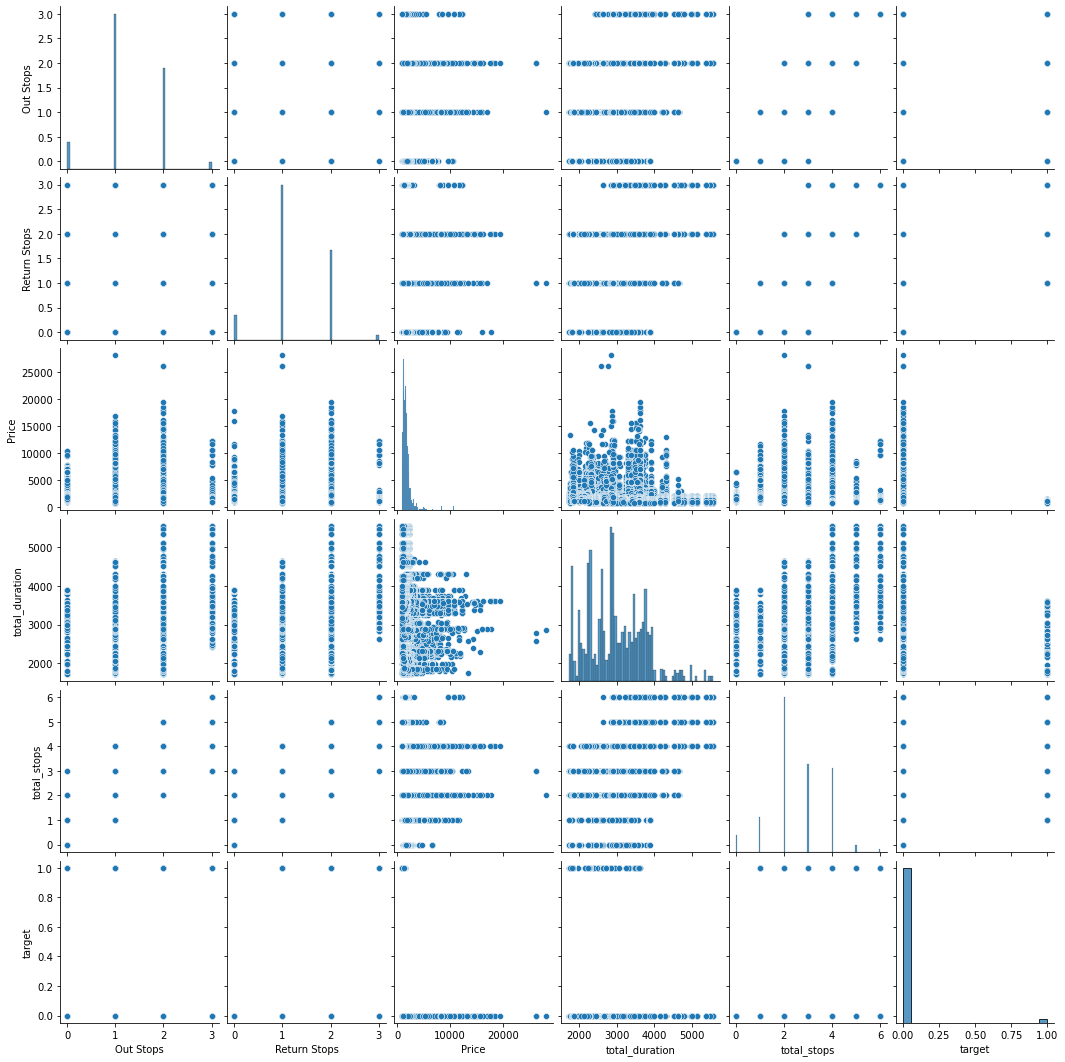

In [9]:
sns.pairplot(df);

<ul>
    <li>We can see that most of the data is relatively equally distributed</li>
    <li>Price is skewed to the right, but that is to be expected because there are outlier plane tickets present like business/first class tickets</li>
</ul>

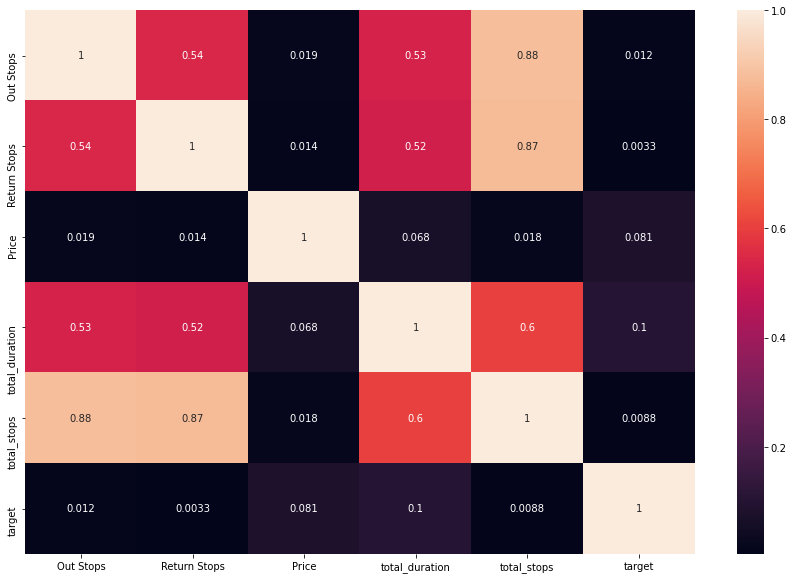

In [10]:
plt.figure(figsize = (15, 10))
sns.heatmap(df.corr().abs(), annot = True);

<ul>
    <li>We see that there is not a lot of multicollinearity present in our data.</li>
    <li>The only variables with high multicollinearity are <code>Total stops</code> , <code>Return Stops</code> , and <code>Out Stops</code></li>
    <li>This is expected simply because we know that they are all directly related to each other.</li>
    <li><code>Total Duration</code> and <code>total_stops</code> also have some collinearity with each other, but it is not at the threshold of <b>0.70</b> where it could be a cut off.</li>
</ul>

In [11]:
time_df = df.set_index(pd.to_datetime(df['departure_date']), drop=True)
ts_price = time_df['Price']

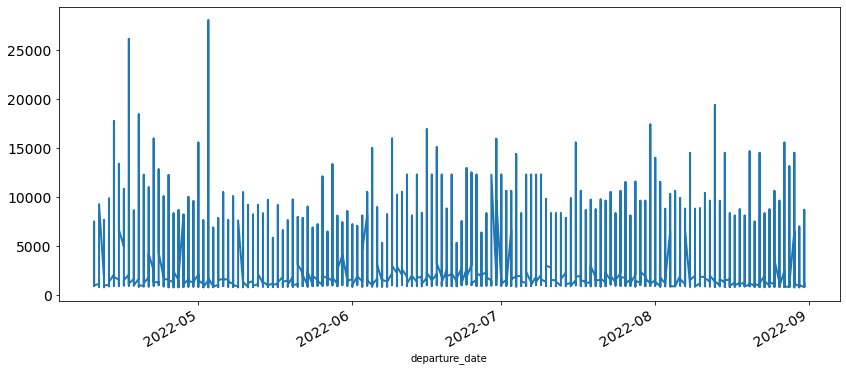

In [12]:
ts_price.plot(figsize=(14,6), linewidth=2, fontsize=14);

<ul>
    <li>We see that our price across time seems stationary.</li>
    <li>In order to confirm this we need to test for stationarity</li>
    <li>In this case I chose to use adfuller</li>
</ul>

In [13]:
# importing relevant library
from statsmodels.tsa.stattools import adfuller

# For testing stationarity
def dicky_fuller(ts):
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(
                    dftest[0:4], 
                    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    alpha = 0.05
    is_stationary = dftest[1] < alpha
    if is_stationary == True:
        print(f'The data is stationary with a fuller score of {round(dftest[1],3)}')
    else:
        print(f'The data is not stationary with a fuller score of {round(dftest[1],3)}')
        
    display(dfoutput)

In [14]:
dicky_fuller(ts_price)

The data is stationary with a fuller score of 0.0


Test Statistic                -1.335585e+01
p-value                        5.550941e-25
#Lags Used                     6.000000e+01
Number of Observations Used    5.865200e+04
Critical Value (1%)           -3.430461e+00
Critical Value (5%)           -2.861589e+00
Critical Value (10%)          -2.566796e+00
dtype: float64

Here we can see that our data is indeed stationary


# Saving the compiled dataframe as <code>masterdf.csv</code>

---

In [15]:
# df.to_csv('data/masterdf.csv', index=False) 